LSTM Autoencoders
Autoencoders Neural Networks try to learn data representation of its input. So the input of the Autoencoder is the same as the output? Not quite. Usually, we want to learn an efficient encoding that uses fewer parameters/memory.

The encoding should allow for output similar to the original input. In a sense, we’re forcing the model to learn the most important features of the data using as few parameters as possible.

Anomaly Detection with Autoencoders
Here are the basic steps to Anomaly Detection using an Autoencoder:

Train an Autoencoder on normal data (no anomalies)
Take a new data point and try to reconstruct it using the Autoencoder
If the error (reconstruction error) for the new data point is above some threshold, we label the example as an anomaly
Good, but is this useful for Time Series Data? Yes, we need to take into account the temporal properties of the data. Luckily, LSTMs can help us with that.

S&P 500 Index Data
Our data is the daily closing prices for the S&P 500 index from 1986 to 2018.

The S&P 500, or just the S&P, is a stock market index that measures the stock performance of 500 large companies listed on stock exchanges in the United States. It is one of the most commonly followed equity indices, and many consider it to be one of the best representations of the U.S. stock market. -Wikipedia

It is provided by Patrick David and hosted on Kaggle. The data contains only two columns/features - the date and the closing price. Let’s download and load into a Data Frame:

In [3]:
import pandas as pd
df = pd.read_csv('spx.csv', parse_dates=['date'], index_col='date')

In [4]:
train_size = int(len(df) * 0.95)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(7782, 1) (410, 1)


In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['close']])

train['close'] = scaler.transform(train[['close']])
test['close'] = scaler.transform(test[['close']])

/var/folders/50/zx6p2vtx3h9bvdft7b3h85sm0000gn/T/ipykernel_4220/1827044255.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['close'] = scaler.transform(train[['close']])
/var/folders/50/zx6p2vtx3h9bvdft7b3h85sm0000gn/T/ipykernel_4220/1827044255.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['close'] = scaler.transform(test[['close']])


In [8]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [10]:
TIME_STEPS = 30
import numpy as np
# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(
  train[['close']],
  train.close,
  TIME_STEPS
)

X_test, y_test = create_dataset(
  test[['close']],
  test.close,
  TIME_STEPS
)

print(X_train.shape)

(7752, 30, 1)


LSTM Autoencoder in Keras
Our Autoencoder should take a sequence as input and outputs a sequence of the same shape. Here’s how to build such a simple model in Keras:

In [12]:
from tensorflow import keras
model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=64,
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(
  keras.layers.TimeDistributed(
    keras.layers.Dense(units=X_train.shape[2])
  )
)

model.compile(loss='mae', optimizer='adam')

Init Plugin
Init Graph Optimizer
Init Kernel
Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2021-09-18 17:27:49.528836: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-09-18 17:27:49.528912: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


There are a couple of things that might be new to you in this model. The RepeatVector layer simply repeats the input n times. Adding return_sequences=True in LSTM layer makes it return the sequence.

Finally, the TimeDistributed layer creates a vector with a length of the number of outputs from the previous layer. Your first LSTM Autoencoder is ready for training.

Training the model is no different from a regular LSTM model:

In [13]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

2021-09-18 17:28:42.634319: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-09-18 17:28:42.634537: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/10


2021-09-18 17:28:43.242059: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-09-18 17:28:43.380477: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-09-18 17:28:43.840697: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-09-18 17:28:44.097542: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


  1/218 [..............................] - ETA: 9:32 - loss: 1.3730

2021-09-18 17:28:45.106062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


218/218 [==============================] - ETA: 0s - loss: 0.1593

2021-09-18 17:28:58.564092: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-09-18 17:28:58.616731: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-09-18 17:28:58.747335: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


218/218 [==============================] - 17s 66ms/step - loss: 0.1593 - val_loss: 0.2620
Epoch 2/10
218/218 [==============================] - 14s 62ms/step - loss: 0.0885 - val_loss: 0.1589
Epoch 3/10
218/218 [==============================] - 13s 62ms/step - loss: 0.0889 - val_loss: 0.1128
Epoch 4/10
218/218 [==============================] - 14s 64ms/step - loss: 0.0891 - val_loss: 0.1090
Epoch 5/10
218/218 [==============================] - 14s 64ms/step - loss: 0.0857 - val_loss: 0.1582
Epoch 6/10
218/218 [==============================] - 14s 64ms/step - loss: 0.0865 - val_loss: 0.2171
Epoch 7/10
218/218 [==============================] - 14s 64ms/step - loss: 0.0858 - val_loss: 0.1870
Epoch 8/10
218/218 [==============================] - 14s 64ms/step - loss: 0.0805 - val_loss: 0.1456
Epoch 9/10
218/218 [==============================] - 14s 66ms/step - loss: 0.0814 - val_loss: 0.1532
Epoch 10/10
218/218 [==============================] - 14s 65ms/step - loss: 0.0878 - val_los

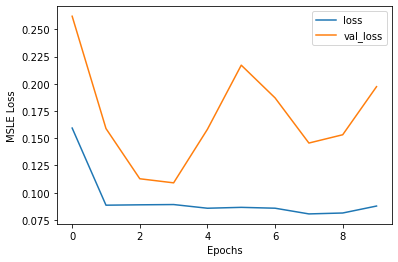

In [15]:
from matplotlib import pyplot as plt 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSLE Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

In [16]:
X_train_pred = model.predict(X_train)

train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

2021-09-18 17:33:49.343769: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-09-18 17:33:49.391364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-09-18 17:33:49.521783: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


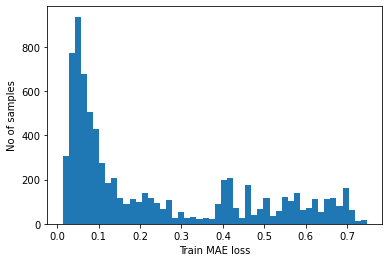

In [18]:
plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

In [22]:
# We’ll pick a threshold of 0.65, as not much of the loss is larger than that. When the error is larger than that, we’ll declare that example an anomaly:
THRESHOLD = 0.65
# calc MAE on test data
X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)
# We’ll build a DataFrame containing the loss and the anomalies (values above the threshold):
test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[TIME_STEPS:].close

In [23]:
anomalies = test_score_df[test_score_df.anomaly == True]

You should have a thorough look at the chart. The red dots (anomalies) are covering most of the points with abrupt changes to the closing price. You can play around with the threshold and try to get even better results. You just combined two powerful concepts in Deep Learning - LSTMs and Autoencoders. The result is a model that can find anomalies in S&P 500 closing price data. You can try to tune the model and/or the threshold to get even better results.